In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import pysheds

import scipy

In [3]:
import sys
sys.path.insert(0, '../modules/')
import model
import utils
import rivernets

In [4]:
path = '../data/'

In [5]:
to_nn = np.array([[-1, 0], [0, 1], [1, 0], [0, -1],
                  [-1, 1], [1, 1], [1, -1], [-1, -1]])

# South America DEM

In [6]:
dem_SouthAmerica, grid_SouthAmerica = rivernets.get_DEM(path + "SouthAmerica.tif", clean = True)

In [7]:
dem_SouthAmerica.min(), dem_SouthAmerica.max()

(Raster(391.00002), Raster(3461.))

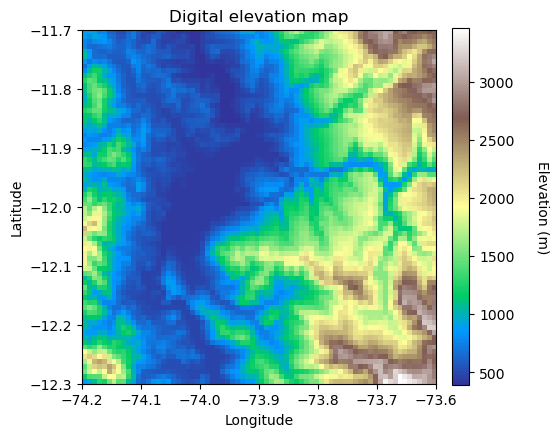

In [8]:
rivernets.plot_DEM(dem_SouthAmerica, grid_SouthAmerica)
plt.show()

In [157]:
slopes = rivernets.get_slopes(dem_SouthAmerica, to_nn = to_nn)

xmin, xmax = np.min(slopes[slopes != np.inf]), np.max(slopes[slopes != np.inf])

ymin = 1e-9
ymax = 1
beta = 0.0015

Dmatrix = rivernets.build_adjacency_elevation_exponential(dem_SouthAmerica, slopes,
                                                          xmin, xmax,
                                                          ymin, ymax,
                                                          beta, to_nn = to_nn)

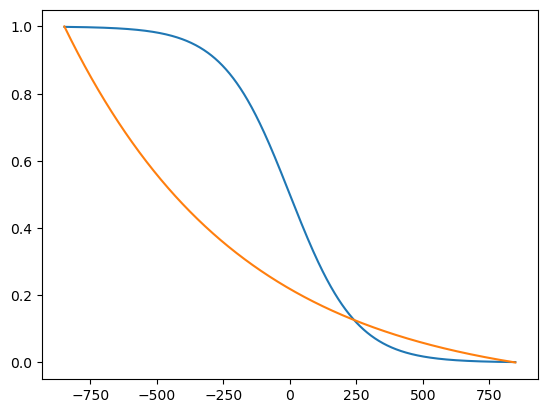

In [158]:
xx = np.linspace(xmin, xmax, 1000)
plt.plot(xx, utils.sigmoid_inv(xx, 0.008))
plt.plot(xx, utils.exponential_range(xx, xmin, xmax, 0, 1, beta = 0.0015))

In [111]:
idx = 195
Dmatrix[idx][Dmatrix[idx] != 0]

array([0.51998934, 0.25730945, 0.09112296, 0.78244978, 0.31431989,
       0.95851288, 0.82346473, 0.450166  ])

In [78]:
utils.linear_to_tuple(idx, dem_SouthAmerica.shape), dem_SouthAmerica[utils.linear_to_tuple(idx, dem_SouthAmerica.shape)]

((2, 51), 1775.0)

In [79]:
dem_SouthAmerica[1:4, 50:53]

Raster([[1771., 1828., 1890.],
        [1711., 1775., 1814.],
        [1618., 1698., 1785.]])

In [80]:
dem_SouthAmerica[2 - 1, 51], dem_SouthAmerica[2, 51 + 1], dem_SouthAmerica[2 + 1, 51], dem_SouthAmerica[2, 51 - 1]

(1828.0, 1814.0, 1698.0, 1711.0)

In [81]:
i,j = utils.linear_to_tuple(idx, dem_SouthAmerica.shape)
ssum = 0
for k, move in enumerate(to_nn):
    s = slopes[i, j, k]
    if s != np.inf:
        idx2 = utils.tuple_to_linear(i + move[0], j + move[1], dem_SouthAmerica.shape)
        print(dem_SouthAmerica[i + move[0], j + move[1]], utils.exponential_range(s, xmin, xmax, ymin, ymax, beta))
        ssum += utils.exponential_range(s, xmin, xmax, ymin, ymax, beta)

1828.0 0.010848264341726938
1814.0 0.011649906465536198
1698.0 0.02097037859020851
1711.0 0.019637593367967342
1890.0 0.00790128450546526
1785.0 0.013500149924550184
1618.0 0.03138624173712879
1771.0 0.014494075448864233


In [82]:
dem_SouthAmerica[2, 51], dem_SouthAmerica[1, 50], utils.exponential_range(-dem_SouthAmerica[2, 51] + dem_SouthAmerica[1, 50], xmin, xmax, ymin, ymax, beta)

(1775.0, 1771.0, 0.014494075448864233)

In [83]:
Dmatrix[int(utils.tuple_to_linear(2, 51, dem_SouthAmerica.shape)), int(utils.tuple_to_linear(1, 50, dem_SouthAmerica.shape))]

0.014494075448864233

In [84]:
Dmatrix.sum(axis = 0)[utils.tuple_to_linear(2, 51, dem_SouthAmerica.shape)]

0.11636259784894645

In [85]:
ssum

0.1303878943814475

In [134]:
Laplacian = utils.find_laplacian_nb(Dmatrix)
Laplacian = Laplacian.astype(np.complex128)
L_eigvals, V, V_inv = utils.diagonalize_matrix(Laplacian.T)

In [135]:
f = 1.5
xi = 2

K_SouthAmerica = model.find_effective_kernel_nb(f, xi, Dmatrix, undirected = False,
                                                Laplacian = Laplacian, L_eigvals = L_eigvals, V = V, V_inv = V_inv)

In [136]:
NDyn = Dmatrix.shape[0]

Nsteps = 20001
dt = 1e-2
cvec = np.ones(NDyn)*1
evec = np.ones(NDyn)*1

Time = np.arange(0, Nsteps*dt, dt)

rho_0 = np.zeros(NDyn)
rho_0[0] = 1

In [137]:
rho_SouthAmerica = model.simulate(NDyn, Nsteps, dt, K_SouthAmerica, cvec, evec, rho0 = rho_0, check_stationary = True)

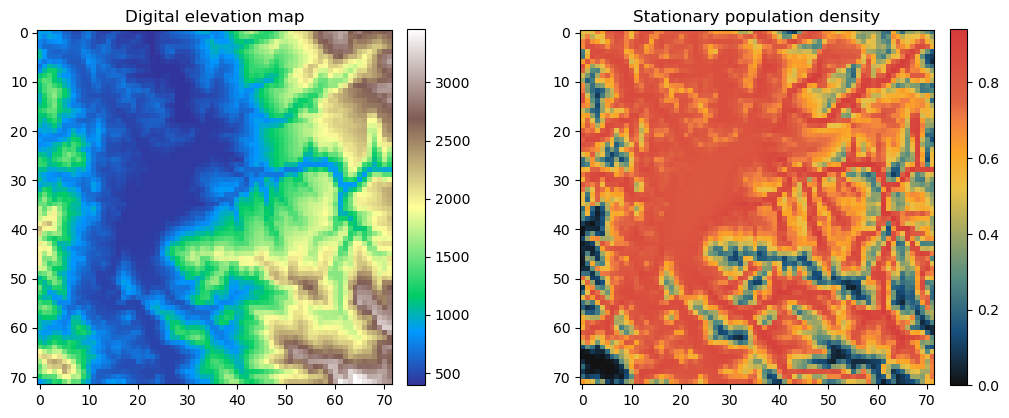

In [138]:
fig, ax = rivernets.plot_DEM_statpop(dem_SouthAmerica, rho_SouthAmerica, vmin = 0)
plt.show()

In [152]:
f = 0.3
xi = 2

K_SouthAmerica = model.find_effective_kernel_nb(f, xi, Dmatrix, undirected = False,
                                                Laplacian = Laplacian, L_eigvals = L_eigvals, V = V, V_inv = V_inv)

In [153]:
NDyn = Dmatrix.shape[0]

Nsteps = 20001
dt = 1e-2
cvec = np.ones(NDyn)*1
evec = np.ones(NDyn)*1

Time = np.arange(0, Nsteps*dt, dt)

rho_0 = np.zeros(NDyn)
rho_0[0] = 1

In [154]:
rho_SouthAmerica = model.simulate(NDyn, Nsteps, dt, K_SouthAmerica, cvec, evec, rho0 = rho_0, check_stationary = True)

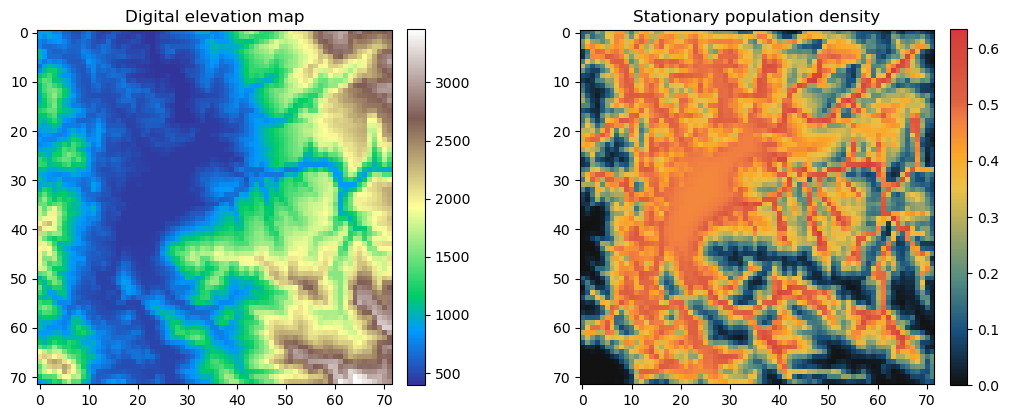

In [155]:
fig, ax = rivernets.plot_DEM_statpop(dem_SouthAmerica, rho_SouthAmerica, vmin = 0)
plt.show()

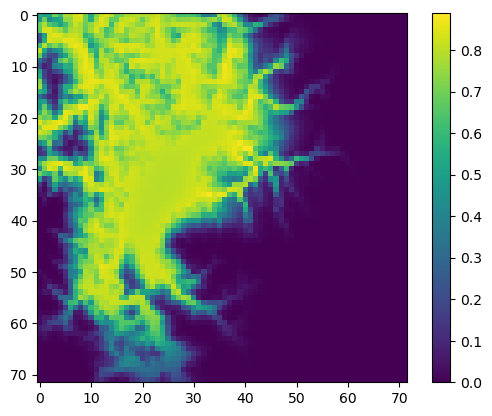

In [139]:
plt.imshow(rho_SouthAmerica[650].reshape(dem_SouthAmerica.shape))
plt.colorbar()

In [22]:
f = 2.5
xi = 5

K_SouthAmerica = model.find_effective_kernel_nb(f, xi, Dmatrix, undirected = False,
                                                Laplacian = Laplacian, L_eigvals = L_eigvals, V = V, V_inv = V_inv)

In [23]:
rho_SouthAmerica = model.simulate(NDyn, Nsteps, dt, K_SouthAmerica, cvec, evec, rho0 = rho_0)

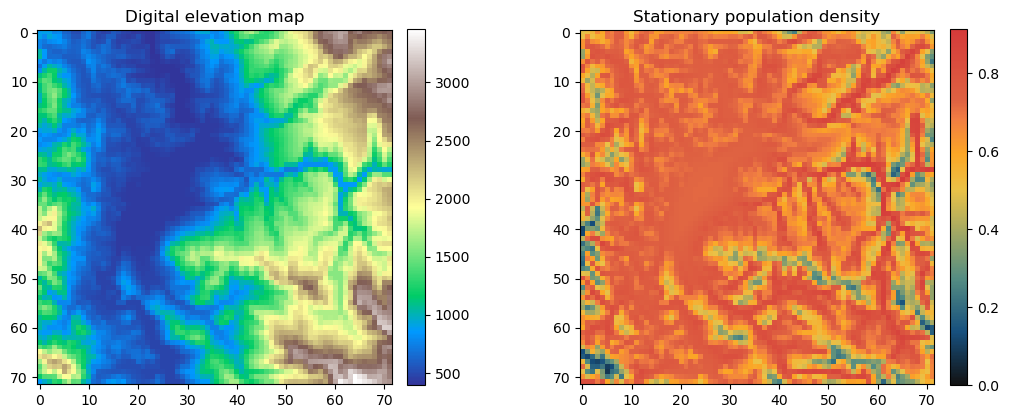

In [24]:
fig, ax = rivernets.plot_DEM_statpop(dem_SouthAmerica, rho_SouthAmerica, vmin = 0)
plt.show()

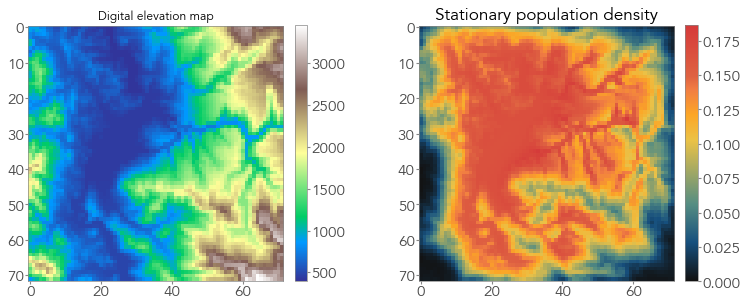

In [542]:
fig, ax = rivernets.plot_DEM_statpop(dem_SouthAmerica, rho_SouthAmerica, vmin = 0)
plt.show()

# Turkey DEM

In [6]:
dem_Turkey, grid_Turkey = rivernets.get_DEM(path + "Turkey.tif", clean = True)

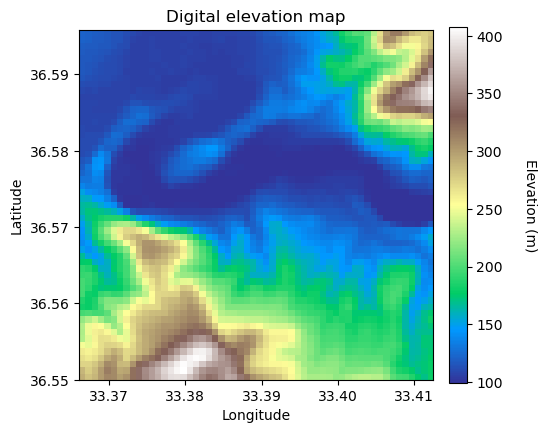

In [7]:
rivernets.plot_DEM(dem_Turkey, grid_Turkey)
plt.show()

In [8]:
slopes_Turkey = rivernets.get_slopes(dem_Turkey, to_nn = to_nn)

In [24]:
ymin_Turkey = 1e-9
ymax_Turkey = 1
beta_Turkey = 0.01

xmin_Turkey, xmax_Turkey = np.min(slopes_Turkey[slopes_Turkey != np.inf]), np.max(slopes_Turkey[slopes_Turkey != np.inf])

Dmatrix_Turkey = rivernets.build_adjacency_elevation_exponential(dem_Turkey, slopes_Turkey,
                                                                 xmin_Turkey, xmax_Turkey,
                                                                 ymin_Turkey, ymax_Turkey, beta_Turkey, to_nn = to_nn)

In [29]:
K_Turkey_new = model.find_effective_kernel_nb(0.5, 2, Dmatrix_Turkey, undirected = False)

In [30]:
NDyn = Dmatrix_Turkey.shape[0]

Nsteps = 10001
dt = 1e-2
cvec = np.ones(NDyn)*1
evec = np.ones(NDyn)*1

Time = np.arange(0, Nsteps*dt, dt)

rho_0 = np.ones(NDyn)*0.1

In [31]:
rhoTurkey_new = model.simulate(NDyn, Nsteps, dt, K_Turkey_new, cvec, evec, rho0 = rho_0)

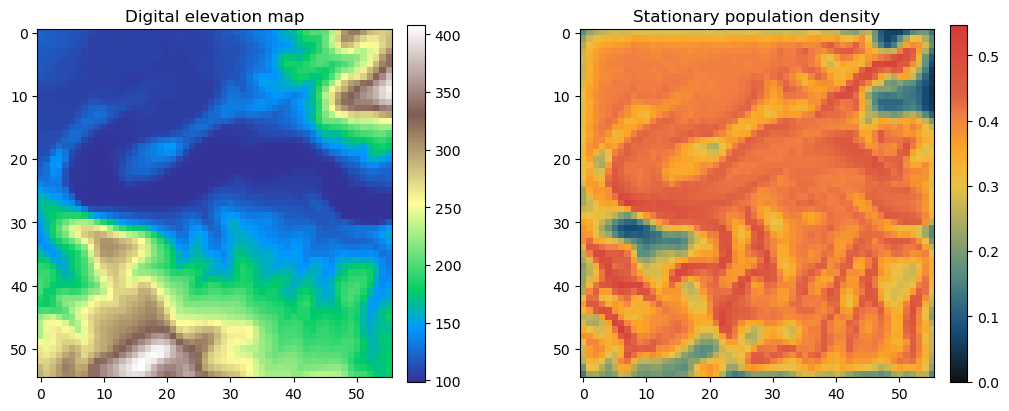

In [32]:
fig, ax = rivernets.plot_DEM_statpop(dem_Turkey, rhoTurkey_new, vmin = 0)
plt.show()

# Asia DEM

In [583]:
dem_Asia, grid_Asia = rivernets.get_DEM(path + "Asia.tif", clean = True)

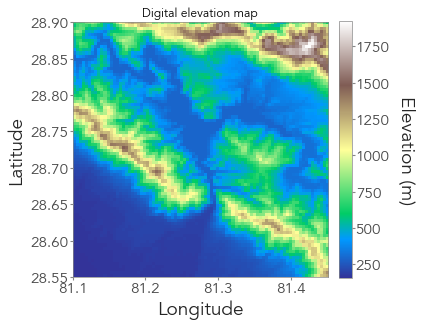

In [584]:
rivernets.plot_DEM(dem_Asia, grid_Asia)
plt.show()

In [585]:
to_nn = np.array([[-1, 0], [0, 1], [1, 0], [0, -1],
                  [-1, 1], [1, 1], [1, -1], [-1, -1]])
slopes_Asia = rivernets.get_slopes(dem_Asia, to_nn = to_nn)

In [334]:
dem_Asia.size

7056

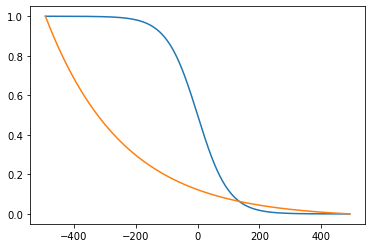

In [335]:
xmin_Asia, xmax_Asia = np.min(slopes_Asia[slopes_Asia != np.inf]), np.max(slopes_Asia[slopes_Asia != np.inf])
xx = np.linspace(xmin_Asia, xmax_Asia, 1000)
plt.plot(xx, utils.sigmoid_inv(xx, 0.02))
plt.plot(xx, utils.exponential_range(xx, xmin_Asia, xmax_Asia, 0, 1, beta = 0.004))

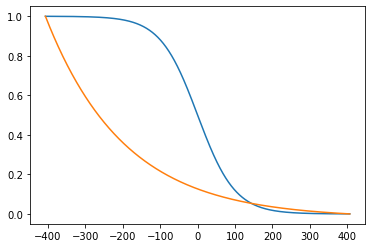

In [293]:
xmin_Asia, xmax_Asia = np.min(slopes_Asia[slopes_Asia != np.inf]), np.max(slopes_Asia[slopes_Asia != np.inf])
xx = np.linspace(xmin_Asia, xmax_Asia, 1000)
plt.plot(xx, utils.sigmoid_inv(xx, 0.02))
plt.plot(xx, utils.exponential_range(xx, xmin_Asia, xmax_Asia, 0, 1, beta = 0.00475))

In [364]:
ymin = 1e-9
ymax = 1
beta_Asia = 0.004

Dmatrix_Asia_new = rivernets.build_adjacency_elevation_exponential(dem_Asia, slopes_Asia, xmin_Asia, xmax_Asia,
                                                                   ymin, ymax, beta_Asia, to_nn = to_nn)

In [365]:
NDyn = Dmatrix_Asia_new.shape[0]

Nsteps = 10001
dt = 1e-2
cvec = np.ones(NDyn)*1
evec = np.ones(NDyn)*1

Time = np.arange(0, Nsteps*dt, dt)

rho_0 = np.ones(NDyn)*0.1

In [366]:
Laplacian_new = utils.find_laplacian_nb(Dmatrix_Asia_new)
Laplacian_new = Laplacian_new.astype(np.complex128)
L_eigvals_new, V_new, V_inv_new = utils.diagonalize_matrix(Laplacian_new.T)

In [367]:
f = 1.5
xi = 2

In [368]:
K_Asia_new = model.find_effective_kernel_nb(f, xi, Dmatrix_Asia_new, undirected = False,
                                            Laplacian = Laplacian_new, L_eigvals = L_eigvals_new, V = V_new, V_inv = V_inv_new)

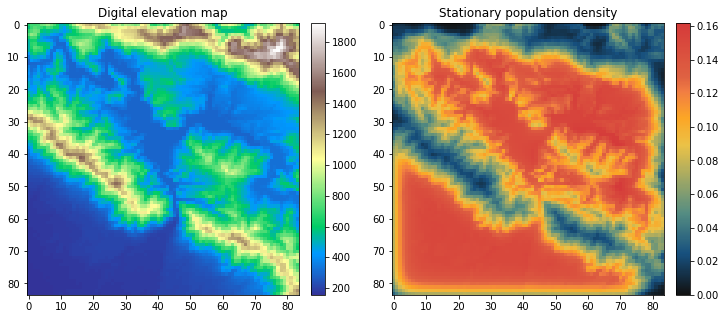

In [369]:
rho_Asia_new = model.simulate(NDyn, Nsteps, dt, K_Asia_new, cvec, evec, rho0 = rho_0)

fig, ax = rivernets.plot_DEM_statpop(dem_Asia, rho_Asia_new, vmin = 0)
plt.show()


In [370]:
f = 0.9
xi = 2

In [371]:
K_Asia_new = model.find_effective_kernel_nb(f, xi, Dmatrix_Asia_new, undirected = False,
                                            Laplacian = Laplacian_new, L_eigvals = L_eigvals_new, V = V_new, V_inv = V_inv_new)

In [376]:
rho_Asia_new = model.simulate(NDyn, Nsteps, dt, K_Asia_new, cvec, evec, rho0 = rho_0)

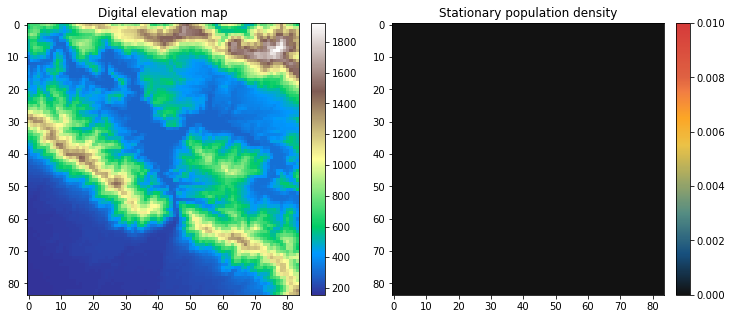

In [375]:
fig, ax = rivernets.plot_DEM_statpop(dem_Asia, rho_Asia_new, vmin = 0, vmax = 0.01)
plt.show()

In [386]:
dx = dy = np.median(abs(slopes_Asia[slopes_Asia != np.inf]).flatten())
pos_3D = rivernets.euclidean_pos_3D(dem_Asia, dx, dy)

distmatrix_Asia = scipy.spatial.distance_matrix(pos_3D.reshape(-1, 3), pos_3D.reshape(-1, 3))

In [387]:
dx

36.0

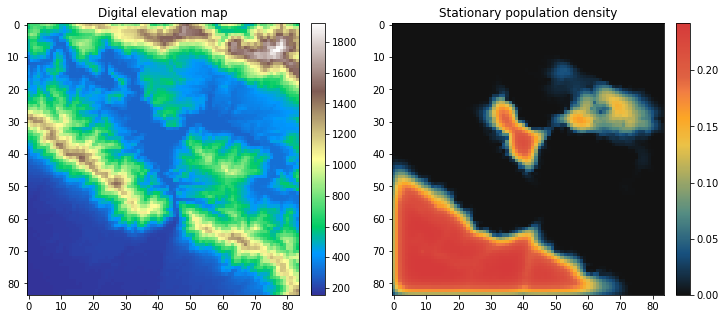

In [391]:
rho_Asia_Hanski = model.simulate_Hanski(NDyn, 10000, dt, distmatrix_Asia, 20, cvec, evec, rho0 = rho_0)
fig, ax = rivernets.plot_DEM_statpop(dem_Asia, rho_Asia_Hanski)
plt.show()

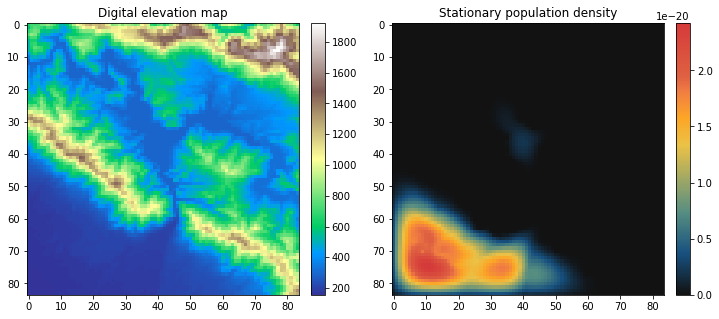

In [392]:
rho_Asia_Hanski = model.simulate_Hanski(NDyn, 10000, dt, distmatrix_Asia, 15, cvec, evec, rho0 = rho_0)
fig, ax = rivernets.plot_DEM_statpop(dem_Asia, rho_Asia_Hanski)
plt.show()

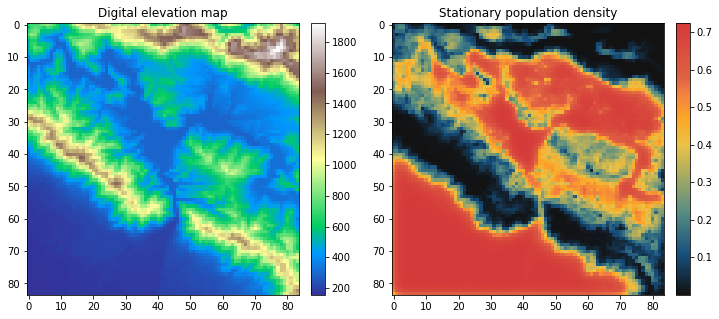

In [390]:
rho_Asia_Hanski = model.simulate_Hanski(NDyn, 10000, dt, distmatrix_Asia, 30, cvec, evec, rho0 = rho_0)
fig, ax = rivernets.plot_DEM_statpop(dem_Asia, rho_Asia_Hanski)
plt.show()

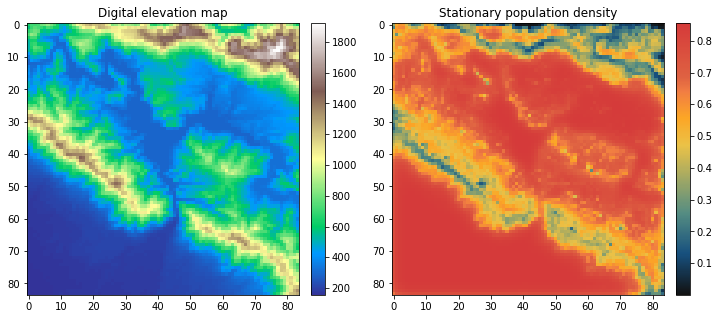

In [393]:
rho_Asia_Hanski = model.simulate_Hanski(NDyn, 10000, dt, distmatrix_Asia, 40, cvec, evec, rho0 = rho_0)
fig, ax = rivernets.plot_DEM_statpop(dem_Asia, rho_Asia_Hanski)
plt.show()

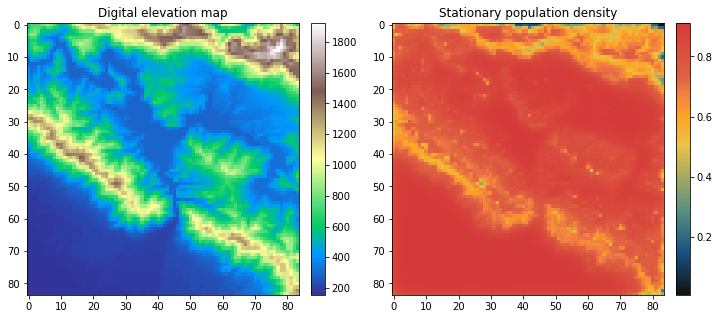

In [394]:
rho_Asia_Hanski = model.simulate_Hanski(NDyn, 10000, dt, distmatrix_Asia, 50, cvec, evec, rho0 = rho_0)
fig, ax = rivernets.plot_DEM_statpop(dem_Asia, rho_Asia_Hanski)
plt.show()